#### Importing Librarires 

In [54]:
import gym, os
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

import math as mt

from pendulum import PendulumEnv

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

'''
seed = 6357502925370079353
seed = 12682774544936231980
'''

'\nseed = 6357502925370079353\nseed = 12682774544936231980\n'

In [56]:
class ActorNetwork(nn.Module):
    def __init__(self, state_space, action_space):
        super(ActorNetwork, self).__init__()
        self.state_space = state_space
        self.action_space = action_space
        self.layer_1 = nn.Linear(self.state_space, 64)
        self.layer_2 = nn.Linear(64, 128)
        self.layer_3 = nn.Linear(128, self.action_space)

    def forward(self, current_state):
        output_layer_1 = F.relu(self.layer_1(current_state))
        output_layer_2 = F.relu(self.layer_2(output_layer_1))
        output_layer_3 = self.layer_3(output_layer_2)
        policy = Categorical(F.softmax(output_layer_3, dim=-1))
        return policy

In [57]:
class CriticNetwork(nn.Module):
    def __init__(self, state_space, action_space):
        super(CriticNetwork, self).__init__()
        self.state_space = state_space
        self.action_space = action_space
        self.layer_1 = nn.Linear(self.state_space, 64)
        self.layer_2 = nn.Linear(64, 128)
        self.layer_3 = nn.Linear(128, 1)

    def forward(self, current_state):
        output_layer_1 = F.relu(self.layer_1(current_state))
        output_layer_2 = F.relu(self.layer_2(output_layer_1))
        state_value = self.layer_3(output_layer_2)
        return state_value

In [58]:
class Classical_Agent():
    def __init__(self, 
                 Actor,
                 Critic,
                 action_space,
                 max_time_steps,
                 actor_learning_rate,
                 critic_learning_rate,
                 discount_factor,
                 number_of_epochs):
        
        self.max_time_steps = max_time_steps
        self.actor_learning_rate = actor_learning_rate
        self.critic_learning_rate = critic_learning_rate
        self.discount_factor = discount_factor
        self.number_of_epochs = number_of_epochs
        self.actions = np.linspace(-1.5,1.5, action_space)

        self.Actor = Actor
        self.Critic = Critic

        self.actor_optimizer = optim.Adam(self.Actor.parameters(), self.actor_learning_rate)
        self.critic_optimizer = optim.Adam(self.Critic.parameters(), self.critic_learning_rate)

    def clear_memory(self):
        self.rewards = []
        self.state_values = []
        self.log_policies = []
        self.done = []

    def replay_memory(self, 
                      state_value,
                      reward,
                      policy,
                      done):
        
        self.log_policies.append(policy)
        self.state_values.append(state_value)
        self.rewards.append(torch.tensor([reward],
                                         dtype = torch.float,
                                         device = device))
        self.done.append(torch.tensor([1-done],
                                      dtype = torch.float,
                                      device = device))
        
    def action_selection(self, 
                         current_state):
        current_state = torch.FloatTensor(current_state).to(device)
        policy = self.Actor(current_state)
        index = policy.sample()
        #print(policy.probs)
        policy = policy.log_prob(index).unsqueeze(0)
        index = index.cpu().numpy()
        action = self.actions[index]

        return action, policy
    
    def compute_discounted_rewards(self, 
                                   next_state_value):
        R = next_state_value
        discounted_rewards = []
        for step in reversed(range(len(self.rewards))):
            R = self.rewards[step] + self.discount_factor * R * self.done[step]
            discounted_rewards.insert(0, R)
        return discounted_rewards
    
    def loss_function(self,
                      discounted_rewards):
        
        self.log_policies = torch.cat(self.log_policies)
        discounted_rewards = torch.cat(discounted_rewards).detach()
        self.state_values = torch.cat(self.state_values)

        advantage = discounted_rewards - self.state_values
        #print('Log probs:', self.log_policies)
        actor_loss = -(self.log_policies * advantage.detach()).mean()
        critic_loss = F.huber_loss(discounted_rewards, self.state_values)

        return actor_loss, critic_loss
    
    def training(self, next_state_value):
        discounted_rewards = self.compute_discounted_rewards(next_state_value)
        actor_loss, critic_loss = self.loss_function(discounted_rewards)

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        return actor_loss.item(), critic_loss.item()

In [59]:
'''enviroment = gym.make("CartPole-v1").unwrapped
action_space = enviroment.action_space.n'''

enviroment = gym.make('Pendulum-v1', g=9.81)
action_space = 5

state_space = enviroment.observation_space.shape[0]


In [60]:
actor_learning_rate = 0.0005
critic_learning_rate = 0.005

max_time_steps = 200
number_of_epochs = 1
number_of_episodes = 5000
discount_factor = 0.99
constant_for_average = 10

Actor = ActorNetwork(state_space = state_space,
                     action_space = action_space).to(device)
Critic = CriticNetwork(state_space = state_space,
                       action_space = action_space).to(device)
Agent = Classical_Agent(Actor = Actor,
                        Critic = Critic,
                        action_space = action_space,
                        max_time_steps = max_time_steps,
                        discount_factor = discount_factor,
                        actor_learning_rate = actor_learning_rate,
                        critic_learning_rate = critic_learning_rate,
                        number_of_epochs = number_of_epochs)

score = []
actor_loss = []
critic_loss = []

average_score = []
average_actor_loss = []
average_critic_loss = []
time_steps = []

for current_episode in range(0, number_of_episodes):
    Agent.clear_memory()
    (current_state, _ ) = enviroment.reset()
    episodic_score  = 0

    for time_step in range(0, max_time_steps):
        enviroment.render()
        current_state = current_state
        action, policy = Agent.action_selection(current_state)
        #print(action, policy)
        '''if action == 0:
            action = -1
        action = 1.5 * action'''
        current_state = torch.FloatTensor(current_state).to(device)
        state_value = Critic(current_state)

        next_state, reward, done, info, _ = enviroment.step([action])
        episodic_score += reward

        Agent.replay_memory(reward = reward,
                            policy = policy,
                            state_value = state_value,
                            done = done)
        
        current_state = next_state
        if done == True:
            break

    next_state = torch.FloatTensor(next_state).to(device)
    next_state_value = Critic(next_state)
    episodic_actor_loss, episodic_critic_loss = Agent.training(next_state_value = next_state_value)

    score.append(episodic_score)
    actor_loss.append(episodic_actor_loss)
    critic_loss.append(episodic_critic_loss)
    time_steps.append(time_step)
    print('Episode:{} Score:{} Actor_Loss:{} Critic_Loss:{}'.format(current_episode, 
                                                                    episodic_score, 
                                                                    episodic_actor_loss, 
                                                                    episodic_critic_loss))
    
for i in range(0,int(len(score)/constant_for_average)):
    temp_score = sum(score[i * constant_for_average : (i+1) * constant_for_average])
    temp_actor_loss = sum(actor_loss[i * constant_for_average : (i+1) * constant_for_average])
    temp_critic_loss = sum(critic_loss[i * constant_for_average : (i+1) * constant_for_average])

    average_score.append(temp_score/10)
    average_actor_loss.append(temp_actor_loss/10)
    average_critic_loss.append(temp_critic_loss/10)

/Users/zam026/Dropbox/CSIRO/Projects/QRL for CartPole/Python Codes/CRL/.venv/lib/python3.11/site-packages/gym/envs/classic_control/pendulum.py:167: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("Pendulum-v1", render_mode="rgb_array")
  gym.logger.warn(
/Users/zam026/Dropbox/CSIRO/Projects/QRL for CartPole/Python Codes/CRL/.venv/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode:0 Score:-1177.921176248773 Actor_Loss:-517.2556762695312 Critic_Loss:326.9502258300781
Episode:1 Score:-1178.8537031849125 Actor_Loss:-530.777099609375 Critic_Loss:331.8687438964844
Episode:2 Score:-1097.4683884364931 Actor_Loss:-518.0438842773438 Critic_Loss:326.8841552734375
Episode:3 Score:-924.6822534454734 Actor_Loss:-423.739013671875 Critic_Loss:268.090087890625
Episode:4 Score:-1170.9653088889727 Actor_Loss:-524.954345703125 Critic_Loss:333.4393615722656
Episode:5 Score:-920.5311194328132 Actor_Loss:-387.2325744628906 Critic_Loss:252.7655792236328
Episode:6 Score:-866.6209604320148 Actor_Loss:-370.9361572265625 Critic_Loss:233.11279296875
Episode:7 Score:-1805.5344176562335 Actor_Loss:-825.7391967773438 Critic_Loss:518.4639892578125
Episode:8 Score:-953.1308895814835 Actor_Loss:-474.4775695800781 Critic_Loss:295.65228271484375
Episode:9 Score:-1096.7272149248079 Actor_Loss:-503.3039855957031 Critic_Loss:318.2890319824219
Episode:10 Score:-1743.7136029869448 Actor_Loss:-8

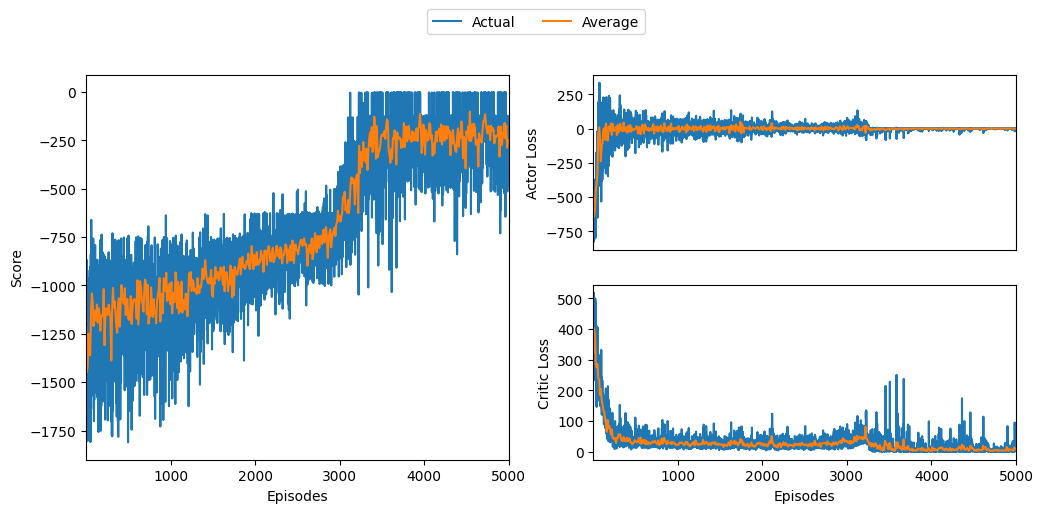

In [61]:
gs = gridspec.GridSpec(2, 2)

fig = plt.figure(figsize=(12,5))
ax = plt.subplot(gs[:,0])
plt.plot(np.array(list(range(0, len(score)))), 
         score, 
         label='Actual')
plt.plot(np.array(list(range(0, len(score), constant_for_average))), 
         average_score, 
         label='Average')
plt.ylabel("Score")
#plt.ylim((0,510))
plt.xlim((1, number_of_episodes))
plt.xlabel("Episodes")

ax = plt.subplot(gs[0,1])
plt.plot(np.array(list(range(0, len(actor_loss)))), 
         actor_loss)
plt.plot(np.array(list(range(0, len(actor_loss), constant_for_average))), 
         average_actor_loss)
#plt.ylim((-30, 30))
plt.xlim((1, number_of_episodes))
plt.xticks([])
plt.ylabel("Actor Loss")

ax = plt.subplot(gs[1,1])
plt.plot(np.array(list(range(0, len(critic_loss)))), 
         critic_loss)
plt.plot(np.array(list(range(0, len(critic_loss), constant_for_average))), 
         average_critic_loss)
#plt.ylim((0,70))
plt.xlim((1, number_of_episodes))
plt.xlabel("Episodes")
plt.ylabel("Critic Loss")

fig.legend( loc="upper center", ncol = 3, bbox_to_anchor=(0.5, 1.025))

In [62]:
'''file = open("Classical_Score_Loss_V8.txt", "x")
data = np.column_stack([score, actor_loss, critic_loss])
np.savetxt("Classical_Score_Loss_V8.txt",data)'''

'file = open("Classical_Score_Loss_V8.txt", "x")\ndata = np.column_stack([score, actor_loss, critic_loss])\nnp.savetxt("Classical_Score_Loss_V8.txt",data)'

In [63]:
'''total_params = sum(p.numel() for p in Critic.parameters())
print(f"Number of parameters: {total_params}")'''

'total_params = sum(p.numel() for p in Critic.parameters())\nprint(f"Number of parameters: {total_params}")'

In [64]:
'''total_params = sum(p.numel() for p in Actor.parameters())
print(f"Number of parameters: {total_params}")'''

'total_params = sum(p.numel() for p in Actor.parameters())\nprint(f"Number of parameters: {total_params}")'

In [65]:
x = np.linspace(-1.5,1.5, 5)
x

array([-1.5 , -0.75,  0.  ,  0.75,  1.5 ])

In [66]:
torch.seed()

9179241210068938147

In [67]:
max(score)

-1.613224755634561